In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df_og = df.copy()

In [4]:
df.head()

id                                       comment_text  toxic  \
0         0000677bf  As others have said it doesn't matter if it wo...      0   
1  0000997932d777bf  I find it extremely telling that Trudeau's lin...      0   
2  000103f0d9cfb60f            Man, is he ever handling this shittily.      0   
3  000113f07ec002fd  Of course he doesn’t want to look into it, he ...      0   
4  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              1  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20619 entries, 0 to 20618
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             20619 non-null  object
 1   comment_text   20619 non-null  object
 2   toxic          20619 non-null  int64 
 3   severe_toxic   20619 non-null  int64 
 4   obscene        20619 non-null  int64 
 5   threat         20619 non-null  int64 
 6   insult         20619 non-null  int64 
 7   identity_hate  20619 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.3+ MB


In [6]:
df.describe()

toxic  severe_toxic       obscene        threat        insult  \
count  20619.000000  20619.000000  20619.000000  20619.000000  20619.000000   
mean       0.097289      0.010961      0.053300      0.003395      0.050924   
std        0.296358      0.104121      0.224637      0.058168      0.219848   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       identity_hate  
count   20619.000000  
mean        0.009166  
std         0.095303  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [7]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [8]:
x=df.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=df.iloc[:,2:].sum(axis=1)
df['clean']=(rowsums==0)
#count number of clean entries
df['clean'].sum()
print("Total comments = ",len(df))
print("Total clean comments = ",df['clean'].sum())
print("Total tags =",x.sum())

Total comments =  20619
Total clean comments =  18495
Total tags = 4640


In [9]:
print("Check for missing values in dataset")
null_check=df.isnull().sum()
print(null_check)

print("filling NA with \"unknown\"")
df["comment_text"].fillna("unknown", inplace=True)

Check for missing values in dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
filling NA with "unknown"


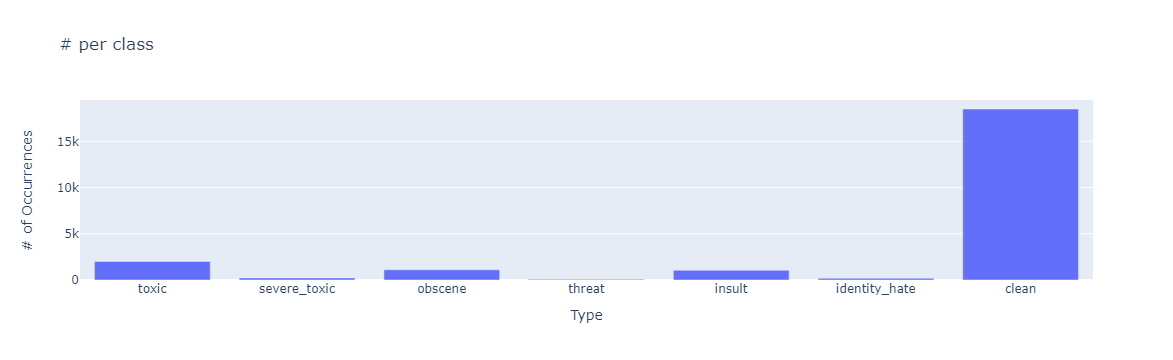

In [10]:
x = df.iloc[:, 2:].sum()

fig = px.bar(x=x.index, y=x.values, 
             title="# per class",
             labels={'x': 'Type', 'y': '# of Occurrences'})
fig.update_layout(xaxis_title="Type", yaxis_title="# of Occurrences")
fig.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems

-> 
There are 20kk comments in thg dataset and there are 181 !?

-> 
This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

### Multi-tagging:
Let's check how many comments have multiple tags.

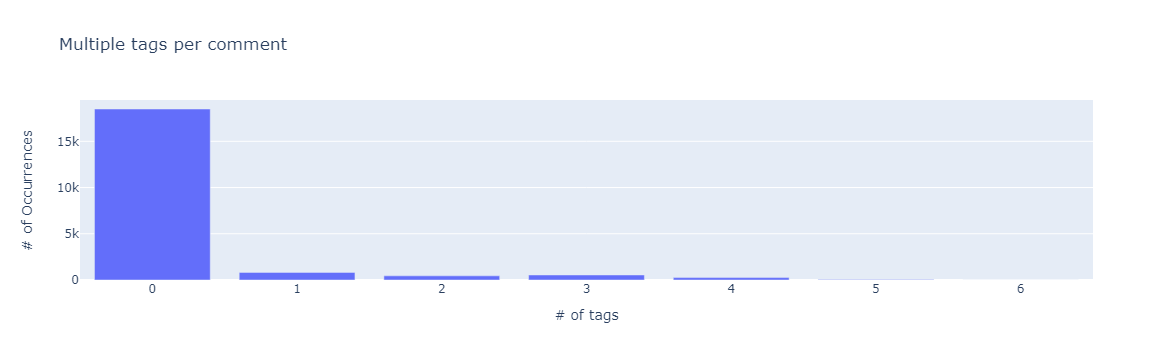

In [11]:
x = rowsums.value_counts()

fig = px.bar(x=x.index, y=x.values, 
             title="Multiple tags per comment",
             labels={'x': '# of tags', 'y': '# of Occurrences'})
fig.update_layout(xaxis_title="# of tags", yaxis_title="# of Occurrences")
fig.show()

Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above

## Which tags go together?
Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.

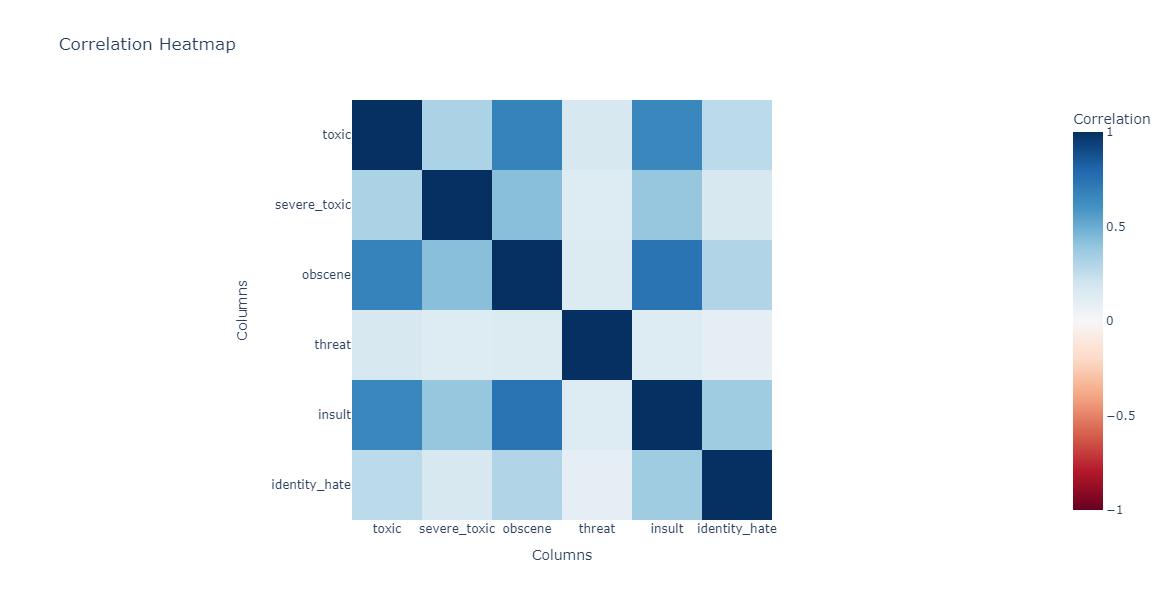

In [12]:
import plotly.express as px

temp_df = df.iloc[:, 2:-1]
# Filter temp by removing clean comments
# temp_df = temp_df[~train.clean]

corr = temp_df.corr()

fig = px.imshow(corr,
                labels=dict(x="Columns", y="Columns", color="Correlation"),
                x=corr.columns,
                y=corr.columns,
                color_continuous_scale='RdBu',
                color_continuous_midpoint=0,
                title="Correlation Heatmap")
fig.update_layout(width=800, height=600)
fig.show()

The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.

So, to find a pattern between two categorical variables we will use other tools like

1. Confusion matrix/Crosstab

In [13]:
# Since checking for all the 6 classes will be difficult
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

In [14]:
out

severe_toxic      obscene       threat     insult       \
severe_toxic            0    1       0     1      0   1      0    1   
toxic                                                                 
0                   18613    0   18550    63  18609   4  18540   73   
1                    1780  226     970  1036   1940  66   1029  977   

             identity_hate       
severe_toxic             0    1  
toxic                            
0                    18600   13  
1                     1830  176

The above table represents the Crosstab of Toxic comments with the other classes.

Some interesting observations:

A Severe toxic comment is always toxic
Other classes seem to be a subset of toxic barring a few exceptions

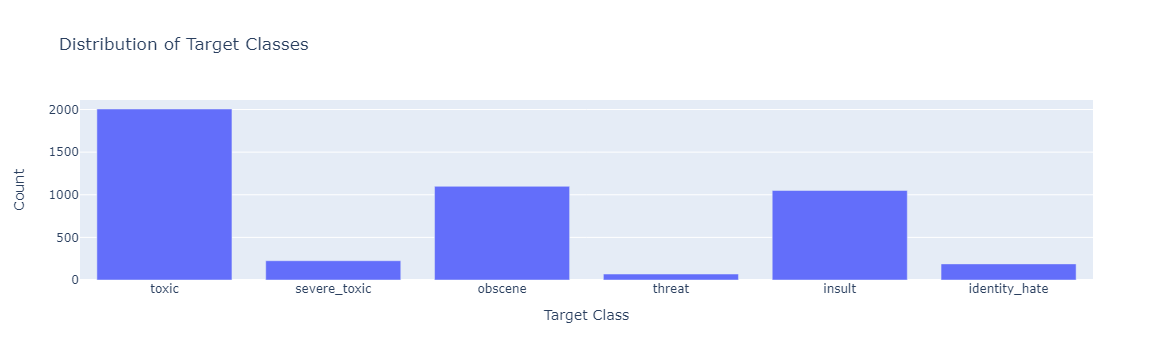

In [15]:
target_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
counts = [df[target_class].sum() for target_class in target_classes]

fig = px.bar(x=target_classes, y=counts, 
             title="Distribution of Target Classes",
             labels={'x': 'Target Class', 'y': 'Count'})
fig.update_layout(xaxis_title="Target Class", yaxis_title="Count")
fig.show()

In [16]:
#For checking first few comments

t = df["comment_text"].to_list()
for i in range(5):
    print('-'*105)
    print('Comment '+str(i+1)+': '+t[i])
    print('-'*105)

---------------------------------------------------------------------------------------------------------
Comment 1: As others have said it doesn't matter if it would of changed the outcome of the election, what matters more is that we have elected officials who are beholden to a hostile country.
---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------
Comment 2: I find it extremely telling that Trudeau's line continues to be "there was no interference that impacted the result of the election." The allegations are not that the CCP helped the Liberals win certain ridings, the allegations are that the CCP hijacked the party nomination process in safe ridings in order to install candidates friendly to their interests. When Trudeau says that this didn't have an impact on the result of the election so it's not a big deal, he's saying that

In [17]:
from wordcloud import WordCloud, STOPWORDS

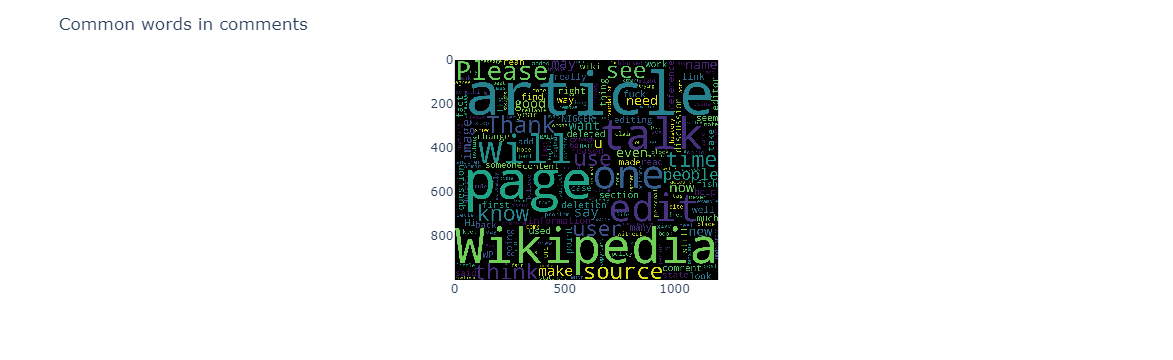

In [18]:
# wordcloud for all comments
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""

text = ' '.join([nonan(abstract) for abstract in df["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
fig = px.imshow(wordcloud)
fig.update_layout(title_text='Common words in comments')

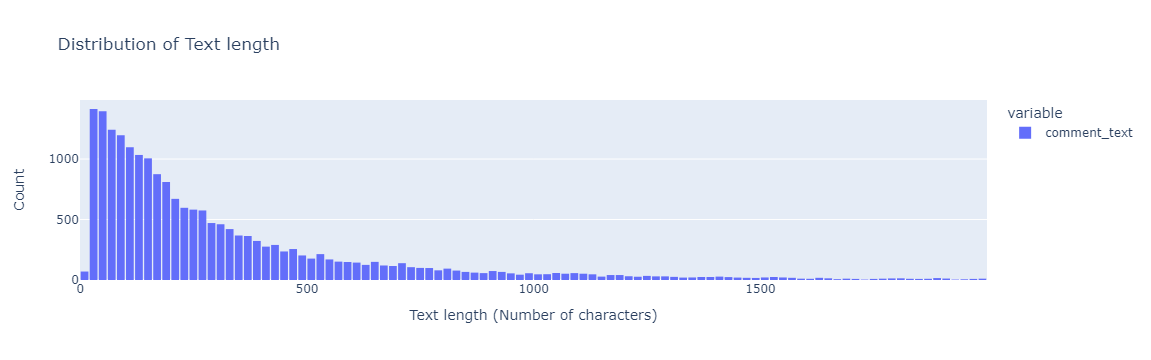

In [19]:
text = df['comment_text'].dropna().map(lambda x: len(x))
text_filtered = text[text < 2000]

fig = px.histogram(text_filtered, 
                   title="Distribution of Text length",
                   labels={'value': 'Text (Number of characters)', 'count': 'Count'})
fig.update_layout(
    xaxis_title="Text length (Number of characters)",
    yaxis_title="Count",
    bargap=0.05,  
    bargroupgap=0.1
)
fig.show()


The length for the text is around 50 characters, we can see that from the above graph

In [20]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
import re
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing## for explainer
import gensim
import gensim.downloader as gensim_api## for deep learning
from tensorflow.keras import backend as K## for bert language model
import transformers

In [21]:
df.drop(columns=["id"],inplace=True)

In [22]:
df.columns

Index(['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean'],
      dtype='object')

In [23]:
from wordcloud import STOPWORDS
#Function to check stopwords as well as remove them

s_words= list(stopwords.words('english'))
from collections import Counter
c = Counter()

extra_s= ["what", "us", "this","well","there","much","us","and","you're","in","where","when","just","how","is","ha","re","are",
          "hi","aren't", 'couldn','could','couldnt',"couldn't",'did','had','have','must','does','should','was',"it's",
          "didn't", "doesn't", "don't", "hadn't", "hasn't", "haven't", "isn't", 'let', 'll',"may",'were','is','has','must',
          'mustn', 'rt', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn','realli','now','got','man','people','a',
          'becaus','caus',"one","im","guy","someone","two",'read', "nearby","i","he's","she's","we","it","they","wouldn’t","i've", 'publications', 'publication',
          'aren', 'didn', 'doesn', 'don','amazon','good', 'content', 'hadn', 'hasn','star', 'haven', 'isn','great', 'subscription', 'sdidn', 've','article','subscribe', 'articles',"will","magazine","magazines","author",'writer','review','pages','issue','document']
stop_words = list(STOPWORDS) + list(s_words) + list(extra_s)

def remove_stopwords(df,column,freq):
      df[column] = df[column].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words and word.lower() not in freq ]))

In [24]:
def preprocess(df, column):
      
    df[column] = df[column].apply(lambda x: "{:.2f}".format(x) if isinstance(x, float) else str(x))
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace('@[^\s]+', '', regex=True)
    df[column] = df[column].str.replace('((www\.[^\s]+)|(https?://[^\s]+))', ' ', regex=True)
    df[column] = df[column].str.replace(r"\d+", " ", regex=True)
    df[column] = df[column].str.replace('&quot;', " ", regex=False)
    df[column] = df[column].str.replace(r"\b[a-zA-Z]\b", "", regex=True)
    df[column] = df[column].str.replace(r"[^\w\s]", " ", regex=True)
    df[column] = df[column].str.replace(r'(.)\1+', r'\1\1', regex=True)
    df[column] = df[column].str.replace(r"\s+", " ", regex=True)
    
    return df[column]


In [25]:
#Function to remove emojis

import emoji
def remove_emojii(df, column):
    df[column] = df[column].apply(lambda x: ' '.join([emoji.replace_emoji(word, replace='') for word in x.split()]))

In [26]:
#Function to check and replace punctuation

import string
def punctuator(df,column):
    df[column] = df[column].apply(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))

In [27]:
#Function to create a Word Cloud

def word_cloud(text):
    stopword_list = set(stop_words)
    word_cloud = WordCloud(width = 550, height = 550,
                           background_color ='black',
                           stopwords = stopword_list,
                           min_font_size = 12).generate_from_text(text)
    plt.figure(figsize = (8, 6))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

In [28]:
remove_stopwords(df=df, column ='comment_text', freq=[])

In [29]:
punctuator(df, column ='comment_text')

In [30]:
remove_emojii(df=df, column ='comment_text')

In [31]:
preprocess(df,column='comment_text')

0        others said matter changed outcome election ma...
1        find extremely telling trudeaus line continues...
2                                    man handling shittily
3        course doesn want look it directly benefited i...
4        make real suggestions improvement wondered sec...
                               ...                        
20614    nancy pelosi high ranking official antiamerica...
20615    aussie currently discussion talkaustraliaa lit...
20616    appreciate lawyer case dismissed sua ponte sch...
20617                           rest case uniform job well
20618    this distortion agree separate mr chase justif...
Name: comment_text, Length: 20619, dtype: object

In [32]:
df.rename(columns={'comment_text':'clean_text'}, inplace=True) 

In [33]:
df

clean_text  toxic  severe_toxic  \
0      others said matter changed outcome election ma...      0             0   
1      find extremely telling trudeaus line continues...      0             0   
2                                  man handling shittily      0             0   
3      course doesn want look it directly benefited i...      0             0   
4      make real suggestions improvement wondered sec...      0             0   
...                                                  ...    ...           ...   
20614  nancy pelosi high ranking official antiamerica...      0             0   
20615  aussie currently discussion talkaustraliaa lit...      0             0   
20616  appreciate lawyer case dismissed sua ponte sch...      0             0   
20617                         rest case uniform job well      0             0   
20618  this distortion agree separate mr chase justif...      0             0   

       obscene  threat  insult  identity_hate  clean  
0            0       0       0              1  False  
1            0       0       0              0   True  
2            0       0       0              0   True  
3            0       0       0              0   True  
4            0       0       0              0   True  
...        ...     ...     ...            ...    ...  
20614        0       0       0              0   True  
20615        0       0       0              0   True  
20616        0       0       0              0   True  
20617        0       0       0              0   True  
20618        0       0       0              0   True  

[20619 rows x 8 columns]

In [34]:
df['y'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
df1 = df[['clean_text', 'y']].rename(columns={'clean_text': 'text'})
df.sample(5)

clean_text  toxic  severe_toxic  \
14957  width stylebackgroundtransparent width styleba...      0             0   
695    regarding edits made december utc kanpur pleas...      0             0   
3917   thanks feedback insight numerous sources claim...      0             0   
3934   invitation wikiproject breakfast stylebordersp...      0             0   
8341    utc comments time offer moment terribly sorry...      0             0   

       obscene  threat  insult  identity_hate  clean  y  
14957        0       0       0              0   True  0  
695          0       0       0              0   True  0  
3917         0       0       0              0   True  0  
3934         0       0       0              0   True  0  
8341         0       0       0              0   True  0

In [35]:
df1['y'].value_counts(normalize=True)

y
0    0.896988
1    0.103012
Name: proportion, dtype: float64

In [36]:
min_len = (df1['y'] == 1).sum()

In [37]:
df_y0_undersample = df1[df1['y'] == 0].sample(n=min_len, random_state=201)

In [38]:
df1 = pd.concat([df1[df1['y'] == 1], df_y0_undersample])

In [39]:
vec = TfidfVectorizer()

In [40]:
X = vec.fit_transform(df1['text'])

In [41]:
df['y'].value_counts()

y
0    18495
1     2124
Name: count, dtype: int64

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, df1['y'], test_size=0.5, random_state=42)

In [43]:
model = MultinomialNB()
model.fit(X_train,y_train)

MultinomialNB()

In [44]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8634651600753296
Precision: 0.8664341322496385
Recall: 0.8634651600753296
F1 Score: 0.8632486728380201
Confusion Matrix:
[[955  98]
 [192 879]]


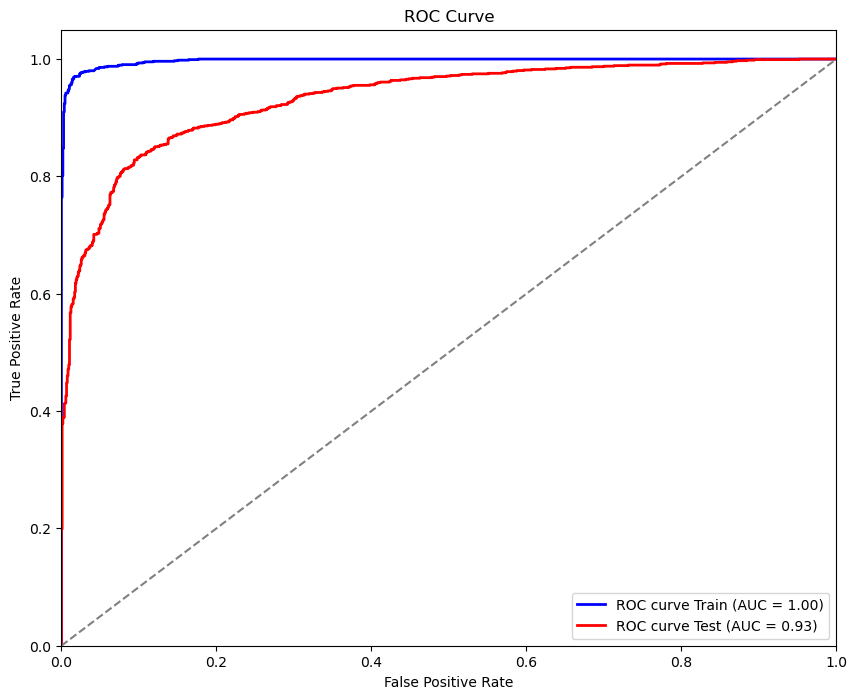

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]


fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
roc_auc_train = auc(fpr_train, tpr_train)


fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve Train (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve Test (AUC = {:.2f})'.format(roc_auc_test))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


The ROC curve shows our model performs well between binary classification and there seems to be no underfitting or overfitting.

UNDERSAMPLING FOR MULTICLASS

In [47]:
min_count = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().min()


undersampled_dfs = []
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    df_label = df[df[label] == 1]
    undersampled_df = df_label.sample(n=min_count, replace=False, random_state=42)
    undersampled_dfs.append(undersampled_df)


undersampled_df = pd.concat(undersampled_dfs)


undersampled_df = undersampled_df.sample(frac=1, random_state=42)


In [48]:
undersampled_df.columns

Index(['clean_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate', 'clean', 'y'],
      dtype='object')

In [49]:
undersampled_df= undersampled_df[['clean_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate']]

In [50]:
undersampled_df.reset_index(inplace=True)

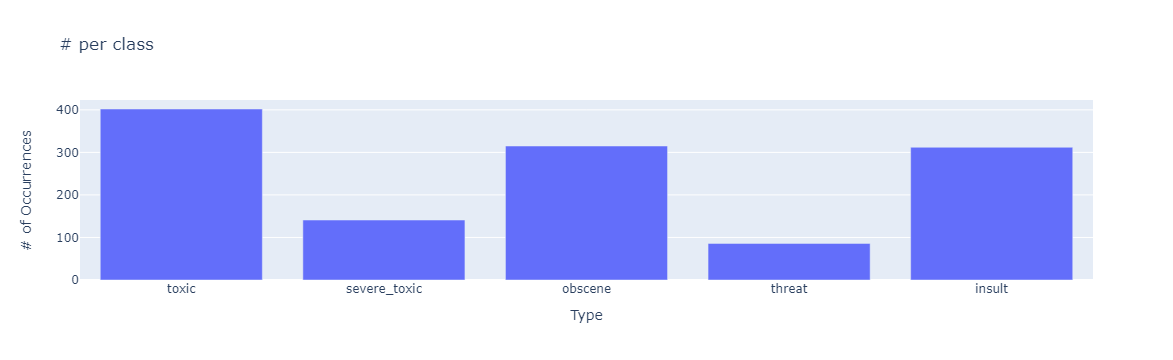

In [51]:
x = undersampled_df.iloc[:, 2:-1].sum()

fig = px.bar(x=x.index, y=x.values, 
             title="# per class",
             labels={'x': 'Type', 'y': '# of Occurrences'})
fig.update_layout(xaxis_title="Type", yaxis_title="# of Occurrences")
fig.show()

In [52]:
kfold = 5
undersampled_df['kfold'] = undersampled_df.index % kfold
undersampled_df.index % kfold

Index([0, 1, 2, 3, 4, 0, 1, 2, 3, 4,
       ...
       0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
      dtype='int64', length=420)

In [53]:
train = undersampled_df[undersampled_df["kfold"] != 0].reset_index(drop = True)
valid = undersampled_df[undersampled_df["kfold"] == 0].reset_index(drop = True)

In [54]:
train.head()

index                                         clean_text  toxic  \
0   7829                                   hai hai hate you      1   
1   2619  smallthingy gay frequent hellfire club shake l...      1   
2  13649  bitch little bitch fuckin spent hours big sam ...      1   
3   9488  piece asian american scum piece asian american...      1   
4   2375  fuck nazi propaganda odpierdalcie sie jebani f...      1   

   severe_toxic  obscene  threat  insult  identity_hate  kfold  
0             0        0       0       1              0      1  
1             0        1       0       1              1      2  
2             1        1       1       1              1      3  
3             1        0       0       1              1      4  
4             1        1       0       0              1      1

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import DataLoader, Dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

import tokenizers
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc

import warnings
warnings.simplefilter('ignore')

In [56]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

In [57]:
senten_len = []

In [58]:
for sentence in tqdm(undersampled_df['clean_text']):
    token_words = tokenizer.encode_plus(sentence)['input_ids']
    senten_len.append(len(token_words))

100%|███████████████████████████████████████████████████████████████████████████████| 420/420 [00:00<00:00, 790.43it/s]


In [59]:
max_len = 200

In [60]:
class BertDataSet(Dataset):
#Bidirectional Encoder Representations from Transformers
    
    
    def __init__(self, sentences, toxic_labels):
        self.sentences = sentences
        #target is a matrix with shape [#1 x #6(toxic, obscene, etc)]
        self.targets = toxic_labels.to_numpy()
    
    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        bert_senten = tokenizer.encode_plus(sentence, 
                                            add_special_tokens = True, # [CLS],[SEP]
                                            max_length = max_len,
                                            pad_to_max_length = True,
                                            truncation = True,
                                            return_attention_mask = True
                                             )
        ids = torch.tensor(bert_senten['input_ids'], dtype = torch.long)
        mask = torch.tensor(bert_senten['attention_mask'], dtype = torch.long)
        toxic_label = torch.tensor(self.targets[idx], dtype = torch.float)
        
        
        return {
            'ids' : ids,
            'mask' : mask,
            'toxic_label':toxic_label
        }

In [61]:
train_dataset = BertDataSet(train['clean_text'], train[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])
valid_dataset = BertDataSet(valid['clean_text'], valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']])

In [62]:
train_dataset

In [63]:
train_batch = 16
valid_batch = 16

In [64]:
train_dataloader = DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 4, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 4, shuffle = False)

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [66]:
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)
model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
for a in train_dataloader:
    ids = a['ids'].to(device)
    mask = a['mask'].to(device)
    output = model(ids, mask)
    break

In [ ]:
output

In [ ]:
func.softmax(output['logits'], dim = 1)

In [ ]:
output_probs = func.softmax(output['logits'], dim = 1)

In [ ]:
torch.max(output_probs, dim = 1)

In [ ]:
epochs = 5
LR = 2e-5 #Learning rate
optimizer = AdamW(model.parameters(), LR, betas = (0.9, 0.999), weight_decay = 1e-2, correct_bias = False)

In [ ]:
train_steps = int((len(train) * epochs)/train_batch)
num_steps = int(train_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer, num_steps, train_steps)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn.to(device)

In [ ]:
scaler = torch.cuda.amp.GradScaler()

In [ ]:
def training(train_dataloader, model, optimizer, scheduler):
    model.train()
    torch.backends.cudnn.benchmark = True
    correct_predictions = 0
    
    for a in train_dataloader:
        losses = []
        optimizer.zero_grad()
        
        #allpreds = []
        #alltargets = []
        
        with torch.cuda.amp.autocast():
            
            ids = a['ids'].to(device, non_blocking = True)
            mask = a['mask'].to(device, non_blocking = True) 

            output = model(ids, mask) #This gives model as output, however we want the values at the output
            output = output['logits'].squeeze(-1).to(torch.float32)

            output_probs = torch.sigmoid(output)
            preds = torch.where(output_probs > 0.5, 1, 0)
            
            toxic_label = a['toxic_label'].to(device, non_blocking = True) 
            loss = loss_fn(output, toxic_label)            
            
            losses.append(loss.item())
            #allpreds.append(output.detach().cpu().numpy())
            #alltargets.append(toxic.detach().squeeze(-1).cpu().numpy())
            correct_predictions += torch.sum(preds == toxic_label)
        
        scaler.scale(loss).backward() #Multiplies (‘scales’) a tensor or list of tensors by the scale factor.
                                      #Returns scaled outputs. If this instance of GradScaler is not enabled, outputs are returned unmodified.
        scaler.step(optimizer) #Returns the return value of optimizer.step(*args, **kwargs).
        scaler.update() #Updates the scale factor.If any optimizer steps were skipped the scale is multiplied by backoff_factor to reduce it. 
                        #If growth_interval unskipped iterations occurred consecutively, the scale is multiplied by growth_factor to increase it
        scheduler.step() # Update learning rate schedule
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(train)*6)
    
    return losses, accuracy

In [ ]:
def validating(valid_dataloader, model):
    
    model.eval()
    correct_predictions = 0
    all_output_probs = []
    
    for a in valid_dataloader:
        losses = []
        ids = a['ids'].to(device, non_blocking = True)
        mask = a['mask'].to(device, non_blocking = True)
        output = model(ids, mask)
        output = output['logits'].squeeze(-1).to(torch.float32)
        output_probs = torch.sigmoid(output)
        preds = torch.where(output_probs > 0.5, 1, 0)
            
        toxic_label = a['toxic_label'].to(device, non_blocking = True)
        loss = loss_fn(output, toxic_label)
        losses.append(loss.item())
        all_output_probs.extend(output_probs.detach().cpu().numpy())
        
        correct_predictions += torch.sum(preds == toxic_label)
        corr_preds = correct_predictions.detach().cpu().numpy()
    
    losses = np.mean(losses)
    corr_preds = correct_predictions.detach().cpu().numpy()
    accuracy = corr_preds/(len(valid)*6)
    
    return losses, accuracy, all_output_probs

In [ ]:
best_score = 1000
train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

for eboch in tqdm(range(epochs)):
    
    train_loss, train_acc = training(train_dataloader, model, optimizer, scheduler)
    valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
    
    print('train losses: %.4f' % train_loss, 'train accuracy: %.3f' % train_acc)
    print('valid losses: %.4f' % valid_loss, 'valid accuracy: %.3f' % valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    
    if valid_loss < best_score:
        best_score = valid_loss
        print('Found a good model!')
        state = {
            'state_dict': model.state_dict(),
            'optimizer_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(state, 'best_model.pth')
    else:
        pass

In [ ]:
x = np.arange(epochs)
fig, ax = plt.subplots(1, 2, figsize = (15,4))
ax[0].plot(x, train_losses)
ax[0].plot(x, valid_losses)
ax[0].set_ylabel('Losses', weight = 'bold')
ax[0].set_xlabel('Epochs')
ax[0].grid(alpha = 0.3)
ax[0].legend(labels = ['train losses', 'valid losses'])

ax[1].plot(x, train_accs)
ax[1].plot(x, valid_accs)
ax[1].set_ylabel('Accuracy', weight = 'bold')
ax[1].set_xlabel('Epochs')
ax[1].legend(labels = ['train acc', 'valid acc'])

ax[1].grid(alpha = 0.3)
fig.suptitle('Fold = 0', weight = 'bold') 

In [ ]:
valid_loss, valid_acc, valid_probs = validating(valid_dataloader, model)
valid_probs = np.asarray(valid_probs).flatten()
y_valid = valid[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].to_numpy().flatten()
fpr, tpr, _ = roc_curve(y_valid, valid_probs)

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curve')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()

Word2Vec+Doc2Vec and Logistic Regression+SVM

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from wordcloud import WordCloud
import requests
from PIL import Image
from io import BytesIO

import re
import spacy
from gensim.models import FastText
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
comment_texts = undersampled_df['clean_text']
target_labels = undersampled_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

X_train, X_test, y_train, y_test = train_test_split(comment_texts, target_labels, test_size=0.2, random_state=42)

In [ ]:
w2v_model = FastText()
w2v_model.build_vocab(corpus_iterable=X_train)

w2v_model.train(corpus_iterable=X_train, total_examples=w2v_model.corpus_count, total_words=w2v_model.corpus_total_words, epochs=5)

In [ ]:
def get_embedding(model, comment):
    words = comment.split()
    embeddings = [model.wv[word] for word in words if word in model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return []
    
X_train_word_emb = X_train.apply(lambda comment: get_embedding(w2v_model,comment)).tolist()
X_train_word_emb = pd.DataFrame(X_train_word_emb)

X_test_word_emb = X_test.apply(lambda comment: get_embedding(w2v_model, comment)).tolist()
X_test_word_emb = pd.DataFrame(X_test_word_emb)

In [ ]:
d2v_train_data = [comment for comment in X_train]

def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(list_of_words, [i])
        
tagged_document = list(create_tagged_document(d2v_train_data))

In [ ]:
d2v_model = Doc2Vec(vector_size=200, min_count=1, epochs=5)
d2v_model.build_vocab(tagged_document)

d2v_model.train(tagged_document, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)


In [ ]:
X_train_doc_emb = X_train.apply(lambda comment: d2v_model.infer_vector(comment.split())).tolist()
X_train_doc_emb = pd.DataFrame(X_train_doc_emb)

X_test_doc_emb = X_test.apply(lambda comment: d2v_model.infer_vector(comment.split())).tolist()
X_test_doc_emb = pd.DataFrame(X_test_doc_emb)

In [ ]:
X_train_word_emb.fillna(0, inplace=True)
X_test_word_emb.fillna(0, inplace=True)

In [ ]:
len(X_test_word_emb)

In [ ]:
len(X_train_word_emb)

In [ ]:

word_models = []
doc_models = []

print("TRAINING LogisticRegression on FastText features")

for i in tqdm(range(6)):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_word_emb, y_train.iloc[:, i])
    word_models.append(model)
   
print("TRAINING LogisticRegression on Doc2Vec features")

for i in tqdm(range(6)):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_doc_emb, y_train.iloc[:, i])
    doc_models.append(model)

In [ ]:
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

predictions_word = []
predictions_doc = []
train_wl = []
train_dl = []


f1_scores_w = []
f1_scores_d = []
f1_scores_tw = []
f1_scores_td = []

for i in range(6):
    model = word_models[i]
    predictions = model.predict(X_test_word_emb)
    train_w = model.predict(X_train_word_emb)
    predictions_word.append(predictions)
    train_wl.append(train_w)
    
for i in range(6):
    model = doc_models[i]
    predictions = model.predict(X_test_doc_emb)
    train_d = model.predict(X_train_doc_emb)
    predictions_doc.append(predictions)
    train_dl.append(train_d)
    
for i, col in enumerate(cols):
    f1_score_w = f1_score(y_test.iloc[:, i], predictions_word[i], average='micro')
    f1_score_1w = f1_score(y_train.iloc[:, i], train_wl[i], average='micro')
    f1_scores_w.append(f1_score_w)
    f1_scores_tw.append(f1_score_1w)
    f1_score_d = f1_score(y_test.iloc[:, i], predictions_doc[i], average='micro')
    f1_score_2d = f1_score(y_train.iloc[:, i], train_dl[i], average='micro')
    f1_scores_d.append(f1_score_d)
    f1_scores_td.append(f1_score_2d)
    print("F1 score for test", col, "with FastText", round(f1_score_w,2))
    print("F1 score for test", col, "with Doc2Vec", round(f1_score_d,2))
    print("F1 score for train", col, "with FastText", round(f1_score_1w,2))
    print("F1 score for train", col, "with Doc2Vec", round(f1_score_2d,2))
    print()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curve for each class
for i, col in enumerate(cols):
    # Calculate ROC curve and AUC for FastText
    fpr_w, tpr_w, _ = roc_curve(y_test.iloc[:, i], predictions_word[i])
    roc_auc_w = auc(fpr_w, tpr_w)
    
    # Calculate ROC curve and AUC for Doc2Vec
    fpr_d, tpr_d, _ = roc_curve(y_test.iloc[:, i], predictions_doc[i])
    roc_auc_d = auc(fpr_d, tpr_d)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_w, tpr_w, color='blue', lw=2, label='ROC curve FastText (AUC = %0.2f)' % roc_auc_w)
    plt.plot(fpr_d, tpr_d, color='green', lw=2, label='ROC curve Doc2Vec (AUC = %0.2f)' % roc_auc_d)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + col)
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

word_models_rf = []
doc_models_rf = []

print("TRAINING RandomForestClassifier on FastText features")

for i in tqdm(range(6)):
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters such as n_estimators
    model_rf.fit(X_train_word_emb, y_train.iloc[:, i])
    word_models_rf.append(model_rf)
   
print("TRAINING RandomForestClassifier on Doc2Vec features")

for i in tqdm(range(6)):
    model_rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters such as n_estimators
    model_rf.fit(X_train_doc_emb, y_train.iloc[:, i])
    doc_models_rf.append(model_rf)


In [ ]:
from sklearn.metrics import f1_score

# Initialize lists to store F1 scores for each class
f1_scores_word_rf = []
f1_scores_doc_rf = []

# Compute F1 score for each class for FastText predictions with Random Forest
for i, col in enumerate(cols):
    f1_score_word_rf = f1_score(y_test.iloc[:, i], word_models_rf[i].predict(X_test_word_emb), average='micro')
    f1_scores_word_rf.append(f1_score_word_rf)

# Compute F1 score for each class for Doc2Vec predictions with Random Forest
for i, col in enumerate(cols):
    f1_score_doc_rf = f1_score(y_test.iloc[:, i], doc_models_rf[i].predict(X_test_doc_emb), average='micro')
    f1_scores_doc_rf.append(f1_score_doc_rf)

# Print F1 scores
print("F1 scores for FastText predictions with Random Forest:")
for i, col in enumerate(cols):
    print(f"F1 score (FastText RF) - {col}: {f1_scores_word_rf[i]}")

print("\nF1 scores for Doc2Vec predictions with Random Forest:")
for i, col in enumerate(cols):
    print(f"F1 score (Doc2Vec RF) - {col}: {f1_scores_doc_rf[i]}")


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curve for each class
for i, col in enumerate(cols):
    # Calculate ROC curve and AUC for FastText with Random Forest
    fpr_w_rf, tpr_w_rf, _ = roc_curve(y_test.iloc[:, i], word_models_rf[i].predict_proba(X_test_word_emb)[:, 1])
    roc_auc_w_rf = auc(fpr_w_rf, tpr_w_rf)
    
    # Calculate ROC curve and AUC for Doc2Vec with Random Forest
    fpr_d_rf, tpr_d_rf, _ = roc_curve(y_test.iloc[:, i], doc_models_rf[i].predict_proba(X_test_doc_emb)[:, 1])
    roc_auc_d_rf = auc(fpr_d_rf, tpr_d_rf)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_w_rf, tpr_w_rf, color='blue', lw=2, label=f'ROC curve FastText RF (AUC = {roc_auc_w_rf:.2f})')
    plt.plot(fpr_d_rf, tpr_d_rf, color='green', lw=2, label=f'ROC curve Doc2Vec RF (AUC = {roc_auc_d_rf:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + col)
    plt.legend(loc='lower right')
    plt.show()


In [ ]:
from sklearn.svm import SVC

# Initialize empty lists to store SVM models for FastText and Doc2Vec
word_models_svm = []
doc_models_svm = []

# Training SVM models for FastText features
print("TRAINING SVM on FastText features")
for i in tqdm(range(6)):
    model = SVC(probability=True)
    model.fit(X_train_word_emb, y_train.iloc[:, i])
    word_models_svm.append(model)

# Training SVM models for Doc2Vec features
print("TRAINING SVM on Doc2Vec features")
for i in tqdm(range(6)):
    model = SVC(probability=True)
    model.fit(X_train_doc_emb, y_train.iloc[:, i])
    doc_models_svm.append(model)


In [ ]:
# Initialize empty lists to store F1 scores for SVM models
f1_scores_word_svm = []
f1_scores_doc_svm = []

# Compute F1 score for each class for FastText predictions with SVM
for i, col in enumerate(cols):
    f1_score_word_svm = f1_score(y_test.iloc[:, i], word_models_svm[i].predict(X_test_word_emb), average='micro')
    f1_scores_word_svm.append(f1_score_word_svm)

# Compute F1 score for each class for Doc2Vec predictions with SVM
for i, col in enumerate(cols):
    f1_score_doc_svm = f1_score(y_test.iloc[:, i], doc_models_svm[i].predict(X_test_doc_emb), average='micro')
    f1_scores_doc_svm.append(f1_score_doc_svm)

# Print F1 scores
print("F1 scores for FastText predictions with SVM:")
for i, col in enumerate(cols):
    print(f"F1 score (FastText SVM) - {col}: {f1_scores_word_svm[i]}")

print("\nF1 scores for Doc2Vec predictions with SVM:")
for i, col in enumerate(cols):
    print(f"F1 score (Doc2Vec SVM) - {col}: {f1_scores_doc_svm[i]}")


In [ ]:
# Plot ROC curve for each class
for i, col in enumerate(cols):
    # Calculate ROC curve and AUC for FastText with SVM
    fpr_w_svm, tpr_w_svm, _ = roc_curve(y_test.iloc[:, i], word_models_svm[i].predict_proba(X_test_word_emb)[:, 1])
    roc_auc_w_svm = auc(fpr_w_svm, tpr_w_svm)
    
    # Calculate ROC curve and AUC for Doc2Vec with SVM
    fpr_d_svm, tpr_d_svm, _ = roc_curve(y_test.iloc[:, i], doc_models_svm[i].predict_proba(X_test_doc_emb)[:, 1])
    roc_auc_d_svm = auc(fpr_d_svm, tpr_d_svm)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_w_svm, tpr_w_svm, color='blue', lw=2, label=f'ROC curve FastText SVM (AUC = {roc_auc_w_svm:.2f})')
    plt.plot(fpr_d_svm, tpr_d_svm, color='green', lw=2, label=f'ROC curve Doc2Vec SVM (AUC = {roc_auc_d_svm:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + col)
    plt.legend(loc='lower right')
    plt.show()


Sequential Model with TF vectorization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
undersampled_df

In [ ]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

X = undersampled_df['clean_text']
y = undersampled_df[undersampled_df.columns[2:-1]].values

MAX_FEATURES = 2000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=200,
                               output_mode='int')
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [ ]:
y

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam')

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [ ]:
#!pip install gradio jinja2
import tensorflow as tf
import gradio as gr
model.save('nlp.hdf5')
model = tf.keras.models.load_model('/kaggle/working/nlp.hdf5')
input_str = vectorizer('hey i freaken hate you!')
res = model.predict(np.expand_dims(input_str,0))
res
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')
interface.launch(share=True)